### **Beijing PM2.5 Dataset for classification**

**Abstract:** 
<p>This hourly data set contains the PM2.5 data of US Embassy in Beijing. Meanwhile, meteorological data from Beijing Capital International Airport are also included.</p>

**Attribute Information:**

|Attributte| Explanation                 ||Attributte| Explanation          |
|  :----   | :----                       ||  :----   | :----                |
|No.       | row number                  ||DEWP.| Dew Point (â„ƒ)           | 
|year.     | year of data in this row    ||TEMP | Temperature (â„ƒ)         | 
|month.    | month of data in this row   ||PRES.| Pressure (hPa)            | 
|day.      | day of data in this row     ||cbwd.| Combined wind direction   | 
|hour.     | hour of data in this row    ||Iws. | Cumulated wind speed (m/s)| 
|pm2.5.    | PM2.5 concentration (ug/m^3)||Is.  | Cumulated hours of snow   | 
|.         |                             ||Ir.  | Cumulated hours of rain   | 

**Data source:**
<p>Liang, X., Zou, T., Guo, B., Li, S., Zhang, H., Zhang, S., Huang, H. and Chen, S. X. (2015). Assessing Beijing's PM2.5 pollution: severity, weather impact, APEC and winter heating. Proceedings of the Royal Society A, 471, 20150257.</p>

In [1]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
print(tf.__version__)

1.13.1


In [2]:
import numpy as np
import pandas as pd
import time
import datetime
import math
import random
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from matplotlib import pyplot

In [3]:
# read data from csv file and process X, y
def data_loader(data_path):
        # load raw data
        df = pd.read_csv(data_path)

        # clean data with missing values          
        '''drop the rows directly -> mess up the order
            first 24 rows have pm2.5 value that is NaN -> discard
            else: forward filling'''
        df = df[24:].fillna(method='ffill')

        # integrate 'year', 'month', 'day', 'hour', 'No' as one attribute
        df['time'] = df.apply(lambda x : datetime.datetime(year=x['year'], month=x['month'], day=x['day'], hour=x['hour']), axis=1)
        df.drop(columns=['year', 'month', 'day', 'hour', 'No'], inplace=True)
        df = df.set_index('time')

        # expand "cbwd" into 4 attributes 'SE', 'cv', 'NW', 'NE'
        df = df.join(pd.get_dummies(df['cbwd'])) # one-hot encoding
        del df['cbwd']

        X = df.iloc[:,1:].astype(np.float32)
        y = df['pm2.5'].astype(np.float32).to_frame()

        return X, y

# split the data into train, val and test set
from sklearn.model_selection import train_test_split
def train_test_val_split(data, ratio_train, ratio_test, ratio_val):
        X_train, X_middle, y_train, y_middle = train_test_split(data[0], data[1], train_size=ratio_train, test_size=ratio_test + ratio_val, shuffle=True)
        ratio = ratio_val/(1-ratio_train)
        X_val, X_test, y_val, y_test = train_test_split(X_middle, y_middle, train_size=ratio, shuffle=True)
        return (X_train, y_train),(X_val, y_val),(X_test, y_test)

# Z-score normalisation
def data_normalisation(train, val, test):
        X_train, y_train = train[0], train[1]
        X_val, y_val = val[0], val[1]
        X_test, y_test = test[0], test[1]

        mean_x, std_x = X_train.mean(axis=0), X_train.std(axis=0)
        mean_y, std_y = y_train.mean(axis=0), y_train.std(axis=0)

        # Use the mean & std of train. Since there's no way for us to know the future.
        (X_train, y_train) = ((X_train-mean_x)/std_x, np.log(np.asarray(y_train) + 1))
        (X_val, y_val) = ((X_val-mean_x)/std_x, np.log(np.asarray(y_val) + 1)) 
        (X_test, y_test) = ((X_test-mean_x)/std_x, np.log(np.asarray(y_test) + 1))

        return (X_train, y_train),(X_val, y_val),(X_test, y_test)

data_path = '../dataset/PM2.5.csv'
X, y = data_loader(data_path)

(X_train, y_train),(X_val, y_val),(X_test, y_test) = train_test_val_split((X.values, y.values), 0.8, 0.1, 0.1)

(X_train, y_train),(X_val, y_val),(X_test, y_test) = data_normalisation((X_train, y_train),(X_val, y_val),(X_test, y_test))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ../saved_model/model_regression/model.ckpt


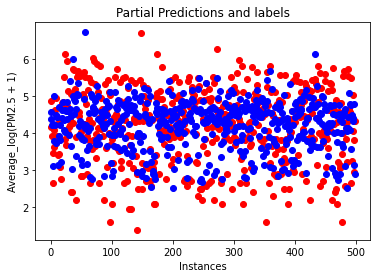

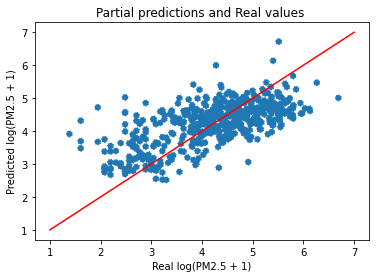

RMSE Score: 0.7397678


In [4]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    new_saver=tf.train.import_meta_graph('../saved_model/model_regression/model.ckpt.meta')
    new_saver.restore(sess,tf.train.latest_checkpoint('../saved_model/model_regression'))
    
    graph = tf.get_default_graph()

    # redefine the structure
    X_p = sess.graph.get_tensor_by_name('X_p:0')
    Y_p = sess.graph.get_tensor_by_name('Y_p:0')

    prediction=tf.get_collection("pred_network")[0]
    loss_ = tf.get_collection("loss")[0]
    RMSE_ = tf.get_collection("RMSE")[0]
    
    # retrain
    y_pred = prediction.eval({X_p: X_test}) 
    loss_score = sess.run(loss_, feed_dict={X_p: X_test,Y_p:y_test})
    eval_RMSE = tf.cast(tf.sqrt(loss_score),dtype=tf.float32)

    # plot prediction and labels
    pyplot.plot(y_test[0:500], 'ro', label='Testing labels')
    pyplot.plot(y_pred[0:500], 'bo', label='Predictions')
    pyplot.xlabel('Instances') 
    pyplot.ylabel('Average_log(PM2.5 + 1)')
    pyplot.title('Partial Predictions and labels')
    pyplot.show()

    pyplot.scatter(y_test[0:500], y_pred[0:500], linestyle="dotted")
    pyplot.plot([1,2,3,4,5,6,7],[1,2,3,4,5,6,7],'r')
    pyplot.xlabel('Real log(PM2.5 + 1)')
    pyplot.ylabel('Predicted log(PM2.5 + 1)')
    pyplot.title('Partial predictions and Real values ')
    pyplot.show()

    # final RMSE
    rmse_score = sess.run(RMSE_,feed_dict={X_p:X_test,Y_p:y_test})
    print("RMSE Score: " + str(rmse_score))